# Adding grid to Pretrained DinoV2 model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/11 23:17:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/11 23:17:23 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024"
test_data_path = "data/parquet_files/PlantCLEF2024_test"

# paths to dataframe
test_path = f"{gcs_path}/{test_data_path}"
# read data
test_df = spark.read.parquet(test_path)
# show
test_df.show(n=5, truncate=50)

+-------------------------------------------+------------------------+--------------------------------------------------+
|                                       path|              image_name|                                              data|
+-------------------------------------------+------------------------+--------------------------------------------------+
| /PlantCLEF2024test/CBN-Pla-B4-20160728.jpg| CBN-Pla-B4-20160728.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-D3-20130808.jpg| CBN-Pla-D3-20130808.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
|/PlantCLEF2024test/CBN-PdlC-E4-20150701.jpg|CBN-PdlC-E4-20150701.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-F5-20150901.jpg| CBN-Pla-F5-20150901.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
| /PlantCLEF2024test/CBN-Pla-D1-20180724.jpg| CBN-Pla-D1-20180724.jpg|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 01 00 4...|
+-----------------------

In [4]:
test_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- image_name: string (nullable = true)
 |-- data: binary (nullable = true)



In [5]:
limit_df = test_df.orderBy("image_name").limit(10).cache()
limit_df.count()

10

In [6]:
import io

import pandas as pd
import timm
import torch
from PIL import Image
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType, MapType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from plantclef.model_setup import setup_pretrained_model
from pyspark.sql import DataFrame
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class PretrainedDinoV2(
    Transformer,
    HasInputCol,
    HasOutputCol,
    DefaultParamsReadable,
    DefaultParamsWritable,
):
    def __init__(
        self,
        pretrained_path: str,
        input_col: str = "input",
        output_col: str = "output",
        model_name: str = "vit_base_patch14_reg4_dinov2.lvd142m",
        batch_size: int = 8,
        grid_size: int = 3,
        use_grid: bool = False,
    ):
        super().__init__()
        self._setDefault(inputCol=input_col, outputCol=output_col)
        self.model_name = model_name
        self.batch_size = batch_size
        self.pretrained_path = pretrained_path
        self.num_classes = 7806  # total number of plant species
        self.local_directory = "/mnt/data/models/pretrained_models"
        self.class_mapping_file = f"{self.local_directory}/class_mapping.txt"
        # Model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = timm.create_model(
            self.model_name,
            pretrained=False,
            num_classes=self.num_classes,
            checkpoint_path=self.pretrained_path,
        )
        self.model.to(self.device)
        self.model.eval()
        # Data transform
        self.data_config = timm.data.resolve_model_data_config(self.model)
        self.transforms = timm.data.create_transform(
            **self.data_config, is_training=False
        )
        self.sql_statement = "SELECT image_name, dino_logits FROM __THIS__"
        self.cid_to_spid = self._load_class_mapping()
        self.grid_size = grid_size
        self.use_grid = use_grid

    def _load_class_mapping(self):
        with open(self.class_mapping_file) as f:
            class_index_to_class_name = {i: line.strip() for i, line in enumerate(f)}
        return class_index_to_class_name

    def _split_into_grid(self, image):
        w, h = image.size
        grid_w, grid_h = w // self.grid_size, h // self.grid_size
        images = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                left = i * grid_w
                upper = j * grid_h
                right = left + grid_w
                lower = upper + grid_h
                crop_image = image.crop((left, upper, right, lower))
                images.append(crop_image)
        return images

    def _make_predict_fn(self):
        def predict(input_data):
            img = Image.open(io.BytesIO(input_data))
            if self.use_grid:
                images = self._split_into_grid(img)
                k = 10
            else:
                images = [img]
                k = 20
            results = []
            for img in images:
                processed_image = self.transforms(img).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    outputs = self.model(processed_image)
                    probabilities = torch.softmax(outputs, dim=1) * 100
                    top_probs, top_indices = torch.topk(probabilities, k=k)
                top_probs = top_probs.cpu().numpy()[0]
                top_indices = top_indices.cpu().numpy()[0]
                result = [
                    {self.cid_to_spid.get(index, "Unknown"): float(prob)}
                    for index, prob in zip(top_indices, top_probs)
                ]
                results.append(result)
            # Flatten the results from all grids, get top 5 probabilities
            flattened_results = [item for grid in results for item in grid[:5]]
            # Sort by score in descending order
            sorted_results = sorted(
                flattened_results, key=lambda x: -list(x.values())[0]
            )
            return sorted_results

        return predict

    def _transform(self, df: DataFrame):
        predict_fn = self._make_predict_fn()
        predict_udf = F.udf(predict_fn, ArrayType(MapType(StringType(), FloatType())))
        return df.withColumn(
            self.getOutputCol(), predict_udf(F.col(self.getInputCol()))
        )

    def transform(self, df) -> DataFrame:
        transformed = self._transform(df)

        for c in self.feature_columns:
            # check if the feature is a vector and convert it to an array
            if "array" in transformed.schema[c].simpleString():
                continue
            transformed = transformed.withColumn(c, vector_to_array(F.col(c)))
        return transformed

    @property
    def feature_columns(self) -> list:
        return ["dino_logits"]

    def pipeline(self):
        return Pipeline(stages=[self, SQLTransformer(statement=self.sql_statement)])

    def run(self, df: DataFrame) -> DataFrame:
        model = self.pipeline().fit(df)
        transformed = model.transform(df)

        return transformed

In [8]:
pretrained_path = setup_pretrained_model()
pretrained_dino = PretrainedDinoV2(
    pretrained_path=pretrained_path,
    input_col="data",
    output_col="dino_logits",
    grid_size=3,
    use_grid=True,
)

Model already exists. Skipping download and extraction.


In [9]:
transformed_df = pretrained_dino.run(df=limit_df).cache()
transformed_df.show(n=5, truncate=50)

+------------------------+--------------------------------------------------+
|              image_name|                                       dino_logits|
+------------------------+--------------------------------------------------+
|CBN-PdlC-A1-20130807.jpg|[{1395807 -> 45.07235}, {1412857 -> 26.177782},...|
|CBN-PdlC-A1-20130903.jpg|[{1392608 -> 45.59701}, {1742052 -> 22.891554},...|
|CBN-PdlC-A1-20140721.jpg|[{1412857 -> 23.853333}, {1391331 -> 20.799023}...|
|CBN-PdlC-A1-20140811.jpg|[{1412857 -> 49.706726}, {1392608 -> 26.205217}...|
|CBN-PdlC-A1-20140901.jpg|[{1392608 -> 46.00654}, {1361281 -> 34.866055},...|
+------------------------+--------------------------------------------------+
only showing top 5 rows



In [10]:
# Assuming `transformed_df` is the DataFrame with the predictions in `dino_logits` column
first_row = transformed_df.select("dino_logits").first()
first_dino_logits = first_row["dino_logits"]

# To visualize the content of the first row
import pprint

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(first_dino_logits)

[ {'1395807': 45.072349548339844},
  {'1412857': 26.17778205871582},
  {'1392608': 25.729400634765625},
  {'1392535': 15.836128234863281},
  {'1392611': 14.548094749450684},
  {'1361273': 11.194877624511719},
  {'1392407': 7.58568811416626},
  {'1392535': 7.042449951171875},
  {'1651363': 6.904348850250244},
  {'1394630': 6.390430927276611},
  {'1392407': 6.323723316192627},
  {'1397468': 5.759836196899414},
  {'1742052': 5.2495927810668945},
  {'1412857': 5.012904644012451},
  {'1412857': 4.456787109375},
  {'1361281': 4.435102462768555},
  {'1397468': 4.169001579284668},
  {'1394911': 3.9906580448150635},
  {'1397535': 3.687161922454834},
  {'1362331': 3.3441338539123535},
  {'1529410': 3.306511402130127},
  {'1394911': 3.0100412368774414},
  {'1394911': 2.7484843730926514},
  {'1392565': 2.67384934425354},
  {'1392558': 2.6493406295776367},
  {'1397535': 2.52866792678833},
  {'1397546': 2.33353328704834},
  {'1529289': 2.2887370586395264},
  {'1362471': 2.2739577293395996},
  {'1397

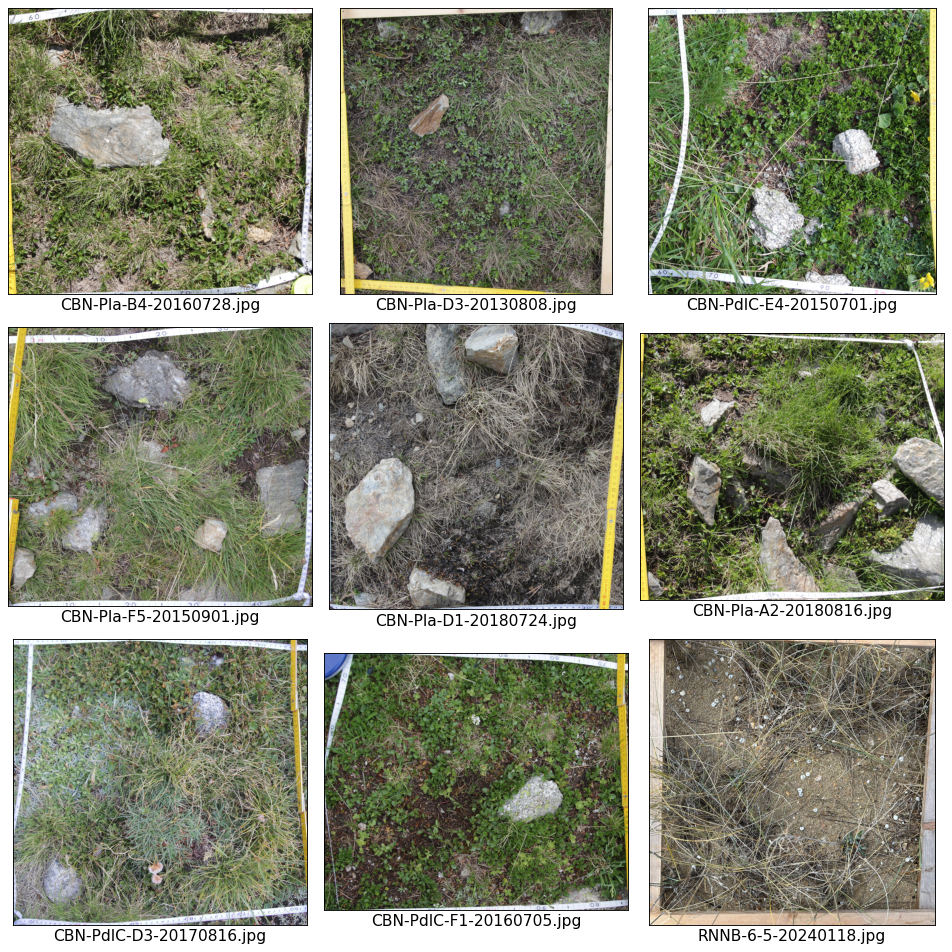

In [11]:
from plantclef.plotting import plot_images_from_binary

# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = limit_df.limit(rows * cols).collect()
image_data_list = [row["data"] for row in subset_df]
image_names = [row["image_name"].replace(".jpg", "") for row in subset_df]

# Display the images in a grid with binomial names
plot_images_from_binary(
    test_df, data_col="data", image_col="image_name", grid_size=(3, 3)
)